## 1. Project Description
### 1.1 Project Objectives
This project has two main objectives:
1. Build an RNN model that predicts (classifies) whether a customer review about restaurants are positive or negative.
2. Build an unsupervised machine model that extracts key topics/themes from reviews.

<br>

### 1.2 Project Background
In order for a business to stay competitive, it needs to understand its customer feedbacks. What are customers saying about us? Are they happy with our products and services? Where do we need to improve upon? 

One important source of customer feedback is the reviews posted on specialized customer review platforms such as Google Reviews and Tripadvisor reviews. These review sites allow customers to post text reviews as well as a rating (usually 1-5 stars). Companies can take these reviews, segment them based on the rating or simply into postive and negative reviews. Companies can then analyze the negative reviews to understand their shortcomings and focus on the positive reviews to further enhance their competitive position.

However, with the advent of smart devices, more and more people are turning to social media to post their experiences with a brand. These social media posts are highly important (due to word of mouth), but much harder for the companies to efficiently analyze, because:
- there are no ratings (1-5)
- have to manually go through each post and sort them into positive/negative reviews, which is very resource intensive for companies

It would therefore be highly valuable, to train an automatic reviews classifier based on reviews that have a rating (e.g. data from specialized reviews platforms, such as Tripadvisor), and use the classifier to predict whether a social media post about a company (such as a Tweet) is positive or negative. In addition, it would be even more valuable to develop a model that can automatically extract keywords/themes from the reviews, as this will give human analysts even more efficient ways to understand and analyze the data.

<br>

### 1.3 Project Evaluation
Part 1 Classification:

Reviews data tend to have imbalanced data distributions:
- either many negative reviews and complaints vs. positive reviews, or
- an overwhelming proportion of positive reviews/high ratings vs. negative reviews

Therefore, accuracy will not be a suitable evaluation metric, as a naive strategy of always predicting the majority class will give us a (misleadingly) high accuracy.

The classification model results will be evaluated using the F1 score. The F1 score is the harmonic mean of precision and recall and it is calculated as:

$$F1 = 2 * \frac{precision\, * \,recall}{precision\, + \,recall}$$

Where

$$precision = \frac{True \, Positives}{True\, Positives \, + \, False \,Positives}$$

$$recall = \frac{True \,Positives}{True\, Positives \, + \, False \,Negatives}$$

Unlike accuracy, the F1 score does not suffer from class imbalance problems, however it is less interpretable than accuracy.

Part 2 Topic Modelling:

Unlike supervised methods, unsupervised methods don't have a "ground truth" to evaluate against. There are mathematical methods such as various distance metrics that can be use for evaluating topic models, but in this project, we feel that it is more important to apply human logic and judgement. Therefore the topic model will be evaluated on whether it provides meaningful and interpretable results.

-------------

## 2. Data Description
### 2.1 Data Understanding
The dataset for this project contains English reviews for restaurants on Tripadvisor. The full dataset contains 6 CSVs, one for each of the following cities: Barcelona, London, Madrid, New Delhi, New York and Pairs. Our project will focus the Barcelona data. 

The Barcelona data contains:
- more than 416k observations (reviews)
- 12 columns/features

Feature definition:
1. parse_count: numerical (integer), corresponding number of extracted review by the web scraper (auto-incremental, starts from 1)
2. author_id: categorical (string), univocal, incremental and anonymous identifier of the user (UID_XXXXXXXXXX)
3. restaurant_name: categorical (string), name of the restaurant matching the review
4. rating_review: numerical (integer), review score in the range 1-5
5. sample: categorical (string), indicating “positive” sample for scores [4-5] and “negative” for scores [1-3]
6. review_id: categorical (string), univocal and internal identifier of the review (review_XXXXXXXXX)
7. title_review: text, review title
8. review_preview: text, preview of the review, truncated in the website when the text is very long
9. review_full: text, complete review
10. date: timestamp, publication date of the review in the format (day, month, year)
11. city: categorical (string), city of the restaurant which the review was written for
12. url_restaurant: text, restaurant url

### 2.2 Data Source and Acknowledgements
The dataset used for this project was found on [Kaggle](https://www.kaggle.com/datasets/inigolopezrioboo/a-tripadvisor-dataset-for-nlp-tasks?select=Barcelona_reviews.csv).

If you use these data, please cite the datasets using the associated [Zenodo DOI](https://doi.org/10.5281/zenodo.6583422) as I am doing here.

If you use these data, please cite the [related paper](https://arxiv.org/abs/2205.01759).

> Botana, Iñigo López-Riobóo, Verónica Bolón-Canedo, Bertha Guijarro-Berdiñas, and Amparo Alonso-Betanzos. "Explain and Conquer: Personalised Text-based Reviews to Achieve Transparency." arXiv preprint arXiv:2205.01759 (2022).

Please notice that these datasets are under a CC-BY-NC 4.0 International license. You must NOT use the material for commercial purposes.


-----------

## 3. Importing the Libraries and Data
### 3.1 Importing the Libraries

In [1]:
# 3.1.1 Importing the common libraries
import pandas as pd
import numpy as np
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

In [2]:
# 3.1.2 Natural Language libraries
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from keras_preprocessing.text import text_to_word_sequence
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# 3.1.3 Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [56]:
# 3.1.4 Deep Learning libraries
import tensorflow as tf
import keras # high-level deep learning API
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import (Embedding,LSTM,
                          Dense,
                          SpatialDropout1D,
                          Bidirectional,
                          BatchNormalization,
                          TimeDistributed, 
                          Dropout, 
                          Flatten, 
                          GlobalMaxPool1D)
from keras.initializers import Constant
from keras.optimizers import adam_v2
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import keras.backend as K

### 3.2 Importing the Data

In [5]:
fulldata = pd.read_csv(r'../input/a-tripadvisor-dataset-for-nlp-tasks/Barcelona_reviews.csv')
fulldata.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (0,1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,parse_count,restaurant_name,rating_review,sample,review_id,title_review,review_preview,review_full,date,city,url_restaurant,author_id
0,0,1,Chalito_Rambla,1,Negative,review_774086112,Terrible food Terrible service,"Ok, this place is terrible! Came here bc we’ve...","Ok, this place is terrible! Came here bc we’ve...","October 12, 2020",Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,UID_0
1,1,2,Chalito_Rambla,5,Positive,review_739142140,The best milanesa in central Barcelona,This place was a great surprise. The food is d...,This place was a great surprise. The food is d...,"January 14, 2020",Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,UID_1
2,2,3,Chalito_Rambla,5,Positive,review_749758638,Family bonding,The food is excellent.....the ambiance is very...,The food is excellent.....the ambiance is very...,"March 7, 2020",Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,UID_2
3,3,4,Chalito_Rambla,5,Positive,review_749732001,Best food,"The food is execellent ,affortable price for p...","The food is execellent ,affortable price for p...","March 7, 2020",Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,UID_3
4,4,5,Chalito_Rambla,5,Positive,review_749691057,Amazing Food and Fantastic Service,"Mr Suarez,The food at your restaurant was abso...","Mr Suarez,The food at your restaurant was abso...","March 7, 2020",Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,UID_4


### 3.2.1 Initial Data Understanding
When we get a dataset it can often be helpful to just run a quick check on the data's key statistics and information. We can understand whether the data has decent quality (values of expected types and in reasonable numerical ranges), and also drop features that are clearly irrelevant to help us save memory (especially on a large dataset).

In [6]:
fulldata.describe(include = 'all')

,Unnamed: 0,parse_count,restaurant_name,rating_review,sample,review_id,title_review,review_preview,review_full,date,city,url_restaurant,author_id
count,416356,416356,416356,416356,416356,416356,416355,416355,416354,416354,416354,416354,416354
unique,416356,416356,6622,11,3,416356,286450,416152,416185,4496,5,45571,232020
top,0,1,Cerveceria_Catalana,5,Positive,review_774086112,Excellent,"Great tapas, a variety of tastes, all tasted e...","Great tapas, a variety of tastes, all tasted e...","October 18, 2016",Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,UID_7046
freq,1,1,5628,203206,338779,1,1495,4,4,413,416325,10,390


In [8]:
fulldata.info()
# memory usage of 41.3+ MB and all features are of "object" type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416356 entries, 0 to 416355
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Unnamed: 0       416356 non-null  object
 1   parse_count      416356 non-null  object
 2   restaurant_name  416356 non-null  object
 3   rating_review    416356 non-null  object
 4   sample           416356 non-null  object
 5   review_id        416356 non-null  object
 6   title_review     416355 non-null  object
 7   review_preview   416355 non-null  object
 8   review_full      416354 non-null  object
 9   date             416354 non-null  object
 10  city             416354 non-null  object
 11  url_restaurant   416354 non-null  object
 12  author_id        416354 non-null  object
dtypes: object(13)
memory usage: 41.3+ MB


We can see based on the previews of the dataset that:
- Unnamed:0, parse_count are irrelevant information, as we already have review_id as the unique id, 
- restaurant_name is not a feature that we are interested in, 
- review_preview and review_full are redundant, and we will only keep review_full,
- date, city and url_restaurant are not features that we are interested in.

We can drop the above mentioned features.

In [7]:
trimdata = fulldata.copy()
trimdata.drop(trimdata.columns[[0,1,2,7,9,10,11,12]], axis = 1, inplace = True) # column index can be read from df.info()
trimdata.head()

,rating_review,sample,review_id,title_review,review_full
0,1,Negative,review_774086112,Terrible food Terrible service,"Ok, this place is terrible! Came here bc we’ve..."
1,5,Positive,review_739142140,The best milanesa in central Barcelona,This place was a great surprise. The food is d...
2,5,Positive,review_749758638,Family bonding,The food is excellent.....the ambiance is very...
3,5,Positive,review_749732001,Best food,"The food is execellent ,affortable price for p..."
4,5,Positive,review_749691057,Amazing Food and Fantastic Service,"Mr Suarez,The food at your restaurant was abso..."


In [10]:
trimdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416356 entries, 0 to 416355
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   rating_review  416356 non-null  object
 1   sample         416356 non-null  object
 2   review_id      416356 non-null  object
 3   title_review   416355 non-null  object
 4   review_full    416354 non-null  object
dtypes: object(5)
memory usage: 15.9+ MB


As we can see, by trimming the unnecessary features off our dataset, we are able to cut down our memory usage from 41MB to just 16MB.

### 3.2.2 Splitting Data to Prevent Data Leakage
It is important to split our data into training and test sets before we perform any analysis to prevent data leakage

In [8]:
# Let's first perform some essential cleaning steps so that our dataframe and feature names make more sense
# 1) swap column orders so that review_id is in front
trimdata = trimdata[['review_id', 'rating_review','sample','title_review','review_full']]

# 2) combine title_review and review_full into a single feature, and rename the feature as just 'review'
# drop the redundant features
trimdata['review'] = trimdata['title_review'] + " " + trimdata['review_full']
trimdata.drop(['title_review','review_full'], axis = 1, inplace = True)

# 3) rename the columns so that they make more sense
trimdata.columns = ['review_id', 'rating', 'sentiment', 'review' ]

In [12]:
trimdata.head()
# looking good

,review_id,rating,sentiment,review
0,review_774086112,1,Negative,"Terrible food Terrible service Ok, this place ..."
1,review_739142140,5,Positive,The best milanesa in central Barcelona This pl...
2,review_749758638,5,Positive,Family bonding The food is excellent.....the a...
3,review_749732001,5,Positive,"Best food The food is execellent ,affortable p..."
4,review_749691057,5,Positive,"Amazing Food and Fantastic Service Mr Suarez,..."


In [9]:
trimdata.dropna(inplace = True) # Note there is one row of 'missing value' as the result of web scraping, so we can safely drop it

In [10]:
X = trimdata.drop('sentiment', axis = 1) # I have a strong feeling that reviews rating is highly imbalanced
y = trimdata.sentiment # So we will set our target to sentiment for now and verify this through EDA in the next section

X_trainval, X_test, y_trainval, y_test = train_test_split(X, 
                                                          y,
                                                          test_size = 0.1, # since data is relatively large, a smaller proportion of test size will do
                                                          stratify = y,
                                                          random_state = 42)

print(f'Size of training and validation sets are X: {X_trainval.shape}, y:{y_trainval.shape}')
print(f'Size of test set is X: {X_test.shape}, y:{y_test.shape}')

Size of training and validation sets are X: (374718, 3), y:(374718,)
Size of test set is X: (41636, 3), y:(41636,)


In [15]:
X_trainval.head()

,review_id,rating,review
150327,review_646954484,5,The best sushi in Barcelona! What a treat! Fre...
43614,review_735484397,5,Fantastic !! Food at this place is simply awes...
113861,review_163709852,4,Worth the wait! Everyone that has been to Bo d...
331406,review_127320404,5,Come and eat here! The hot and sour soup was t...
143261,review_150510792,5,Amazing LLamber Finally an amazing & high qual...


In [16]:
y_trainval.head()

150327    Positive
43614     Positive
113861    Positive
331406    Positive
143261    Positive
Name: sentiment, dtype: object

-----------------

## 4. Exploratory Data Analysis (EDA)
EDA serves two main purposes:

1. Verifying data quality: guides us in data cleaning and preparation
* Missing values
* Duplicate entries
* Inconsistent entries and labels
* Outliers
* Rare categorical classes
* etc...
2. Exploring data characteristics: guides us in feature engineering
* Patterns unique/interesting in the data
* Feature characteristics and distribution
* etc...

### 4.1 Data Quality Exploration
#### 4.1.1 Missing Values
As expected, we have no missing values right now.

<AxesSubplot:>

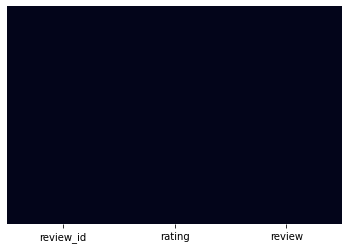

In [17]:
sns.heatmap(X_trainval.isnull(), annot = False, cbar = False, yticklabels = False)

#### 4.1.2 Duplicate entries
We are particularly interested in "review" that are duplicated.

In [18]:
X_trainval.review.duplicated().sum()

54

In [19]:
X_trainval[X_trainval.review.duplicated()]

,review_id,rating,review
259147,review_326210272,5,Gorgeous Spectacular interiors & ambiance in b...
401341,review_587098850,5,מסעדה מעולה We at the restaurant following the...
308220,review_238144445,5,one of the best chinese meals Tired of tapas. ...
400438,review_361748442,5,Best tapas bar :) I went there basicly everyda...
222384,review_436836159,5,"Baby calamar Delicious sea foods,tapas and Med..."
339126,review_168784354,2,"Surly waiters. Non-attentive waitstaff, with d..."
341018,review_510896108,1,Unreliable... In the past 6 months our working...
268209,review_163005960,4,Worth a stop. We stopped here for a snack/drin...
259621,review_343965454,5,"Bueaitful surroundings, great food Visited whi..."
284914,review_428419497,4,Worth a visit I can see very missed reviews so...


Although df.duplicated() is suggesting that we have duplicate data, but on closer inspection, the reviews are not actually identical, so we will proceed using the current data.

### 4.1.3 Inconsistent Entries or Labels

In [20]:
X_trainval.rating.unique()

array(['5', 5, 4, '2', 3, 2, '4', '1', 1, '3'], dtype=object)

In [21]:
X_trainval.rating.value_counts()

5    182963
4     72323
5     34847
3     25378
1     21059
4     14767
2     14017
3      4453
1      2584
2      2327
Name: rating, dtype: int64

We can see that some ratings are numerical while others are strings in terms of data format, this is clearly problematic, and requires cleaning.

In [22]:
y_trainval.unique()

array(['Positive', 'Negative'], dtype=object)

The target labels are consistent, and free from spelling variations, which is good. Often times though, we tend to see inconsistent labelling (especially in casing), e.g. Positive vs. positive, in those cases, we need to clean up the data.

### 4.2 Data Characteristic Exploration

In [11]:
# Let's first combine X trainval and y trainval for easier manipulation
edadata = pd.concat([X_trainval, y_trainval], axis = 1)
edadata.head()

,review_id,rating,review,sentiment
150327,review_646954484,5,The best sushi in Barcelona! What a treat! Fre...,Positive
43614,review_735484397,5,Fantastic !! Food at this place is simply awes...,Positive
113861,review_163709852,4,Worth the wait! Everyone that has been to Bo d...,Positive
331406,review_127320404,5,Come and eat here! The hot and sour soup was t...,Positive
143261,review_150510792,5,Amazing LLamber Finally an amazing & high qual...,Positive


#### 4.2.1 Exploration Feature Distribution
**rating**

Even without fixing the mislabelled data, we can quite clearly see that rating = 5 and = 4 have the most observations, far above the other ones.

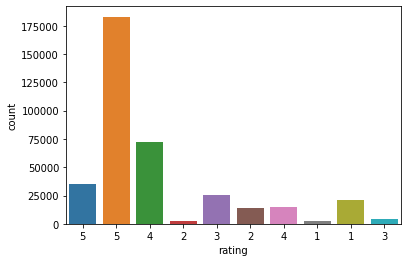

In [24]:
sns.countplot(x = edadata.rating);

**sentiment**
We can see that even with rating = 1,2,3 combined as "Negative", we still have an imbalanced target variable. This confirm my initial feeling that review data tends to be very imbalanced. We will need to take this into account when building our models.

<AxesSubplot:xlabel='sentiment', ylabel='count'>

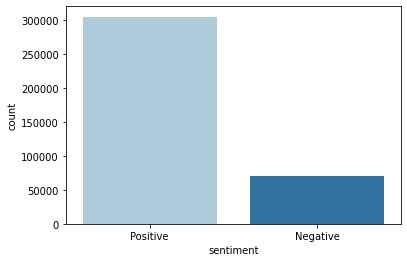

In [25]:
sns.countplot(x = edadata.sentiment, palette = "Paired")

In [26]:
edadata.sentiment.value_counts(normalize = True)

Positive    0.813679
Negative    0.186321
Name: sentiment, dtype: float64

#### 4.2.2 Distribution of characters and words in a review
It seems that negative reviews have more characters than positive reviews (makes sense!).

In [27]:
pos_review = edadata[edadata.sentiment == 'Positive']
neg_review = edadata[edadata.sentiment == 'Negative']
print(f"Average character length of positive reviews is {round(pos_review.review.str.len().mean())}")
print(f"Average character length of negative reviews is {round(neg_review.review.str.len().mean())}")

Average character length of positive reviews is 386
Average character length of negative reviews is 526


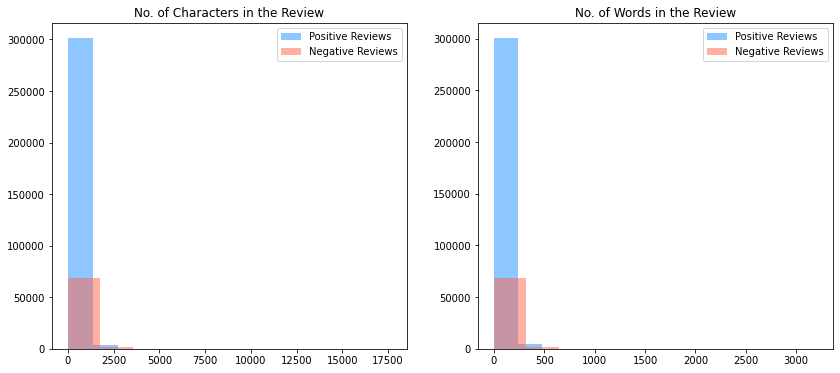

In [28]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14, 6))

# characters
pos_char_len = pos_review['review'].str.len()
neg_char_len = neg_review['review'].str.len()
ax1.hist(pos_char_len, alpha = 0.5, label = 'Positive Reviews', color = 'dodgerblue')
ax1.hist(neg_char_len, alpha = 0.5, label = 'Negative Reviews', color = 'tomato')
ax1.legend()
ax1.title.set_text("No. of Characters in the Review")

# words
pos_word_len = pos_review['review'].str.split().apply(lambda x: len(x))
neg_word_len = neg_review['review'].str.split().apply(lambda x: len(x))
ax2.hist(pos_word_len, alpha = 0.5, label = 'Positive Reviews', color = 'dodgerblue')
ax2.hist(neg_word_len, alpha = 0.5, label = 'Negative Reviews', color = 'tomato')
ax2.legend()
ax2.title.set_text("No. of Words in the Review")

We can see some clear outliers here.

In [13]:
edadata['char_len'] = edadata['review'].str.len()
edadata['word_len'] = edadata['review'].str.split().apply(lambda x: len(x))
edadata.describe()

,char_len,word_len
count,374718.000000,374718.000000
mean,412.140746,74.274094
std,329.411701,60.804825
min,9.000000,2.000000
25%,203.000000,36.000000
50%,317.000000,57.000000
75%,509.000000,92.000000
max,17650.000000,3207.000000


In [30]:
edadata[edadata['char_len'] > 2000].head()

,review_id,rating,review,sentiment,char_len,word_len
165948,review_289957995,5,Thank you for the excellent food & wonderful e...,Positive,2544,448
40209,review_135602863,2,I probably won´t go back I had read all review...,Negative,2228,419
146751,review_460776310,4,Twice in one trip I loved this restaurant for ...,Positive,3042,551
1729,review_636943895,5,Best meal ever! So my friends and I went to Ba...,Positive,2084,411
6732,review_179116768,5,Best meal ever! Both my wife and I thought thi...,Positive,2623,482


In [31]:
edadata.loc[6732,:].review

"Best meal ever! Both my wife and I thought this was the best meals we both had ever. We are both from Toronto and I don't think there is a restaurant there than can top this one. This probably tops the restaurants we have visited in barcelona so far and tops the vacation so far. We had a 730pm reservation on a Sunday. I reserved the restaurant based upon the reviews on trip advisor. They were expecting us and actually knew our names as we entered the restaurant. The dining is intimate, dimly lit, and small which adds a romantic feel. The restaurant was almost empty when we entered but filled up quickly as the night progressed. The service at the restaurant was excellent, taking the time to explain the dishes and the wines. The staff were always nearby which makes the small restaurant feel work.  We both had the surprise tasting menu. I had the wine pairing and my wife did not. Each table that chose the surprise menu had slightly different courses. This is what we had. They were willin

In [32]:
edadata[edadata['char_len'] > 10000].head()

,review_id,rating,review,sentiment,char_len,word_len
106961,review_352140203,1,"The Curse of the two Michelin Stars So, to put...",Negative,17650,3207
182510,review_586241840,5,RESTAURANT REINVENTED ENIGMA Concept RESTAURA...,Positive,10159,1546
128388,review_231212570,5,Great fun restaurant Photos on blog. Opening R...,Positive,13717,2373
154776,review_240142343,4,Great food at ABaC PHOTOS & FULL REVIEW Abbeys...,Positive,10940,1864
407831,review_585205861,5,CAELIS...as in GASTRONOMIC HEAVENS ! CAELIS RE...,Positive,13477,2145


In [33]:
edadata.loc[407831,:].review

'CAELIS...as in GASTRONOMIC HEAVENS ! CAELIS RESTAURANT  CAELIS... as in gastronomic HEAVENS!  CARTAS DE AMOR PARA BARCELONA  Chapter 1  Love Letters to Barcelona  Love letters to the land of my grand parents... This is my "kind of review"; the one that I joyfully, dearly love to write.... A review about enjoying a new experience in a great gastronomic place... A place were palate pleasing and artistry abounds.  This are “my kind" of review lines. The ones that-in my own style- flows from my mind-when my heart and soul are touched by true-gastronomic recipes, artistically worked and served with style on plates and, beyond that; served, as well, on a nice, tasteful ambiance... like it was here at "Caelis”.  Before involving myself in this Review notes: I’m obliged to NOTE that “Caelis”, named by his well known and praised chef Romain Fornell (originally from Toulouse) is holding 1 Michelin ⭐️ Star. In my humble opinion, after been in many-many starred restaurants not only in Spain, but 

Although these are genuine reviews, but they are also very lengthy and would make our text representation quite high dimensional. So we will truncate these very long reviews and remove them from our data set.

In [15]:
ninetypercentile = edadata.char_len.quantile(0.90)
ninetypercentile

776.0

In [16]:
edadata_trim = edadata.copy()
edadata_trim = edadata[edadata.char_len <= ninetypercentile]
edadata_trim.describe()

,char_len,word_len
count,337276.000000,337276.000000
mean,330.145937,59.152946
std,166.095334,30.956594
min,9.000000,2.000000
25%,193.000000,34.000000
50%,291.000000,52.000000
75%,436.000000,79.000000
max,776.000000,167.000000


In [36]:
pos_review = edadata_trim[edadata_trim.sentiment == 'Positive']
neg_review = edadata_trim[edadata_trim.sentiment == 'Negative']
print(f"Average character length of positive reviews is {round(pos_review.review.str.len().mean())}")
print(f"Average character length of negative reviews is {round(neg_review.review.str.len().mean())}")

Average character length of positive reviews is 322
Average character length of negative reviews is 368


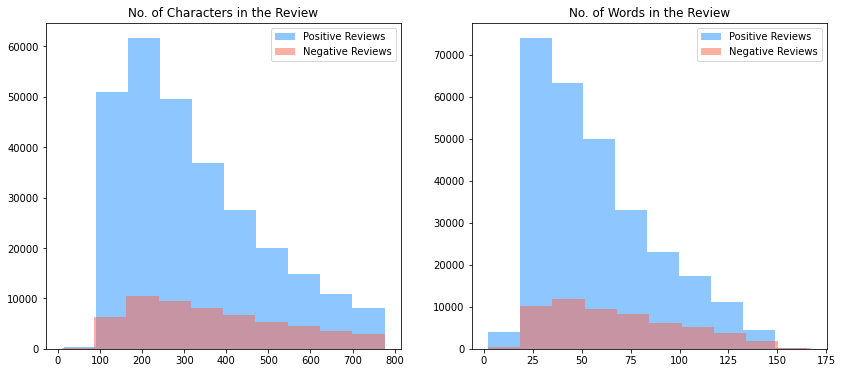

In [37]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14, 6))

# characters
pos_char_len = pos_review['review'].str.len()
neg_char_len = neg_review['review'].str.len()
ax1.hist(pos_char_len, alpha = 0.5, label = 'Positive Reviews', color = 'dodgerblue')
ax1.hist(neg_char_len, alpha = 0.5, label = 'Negative Reviews', color = 'tomato')
ax1.legend()
ax1.title.set_text("No. of Characters in the Review")

# words
pos_word_len = pos_review['review'].str.split().apply(lambda x: len(x))
neg_word_len = neg_review['review'].str.split().apply(lambda x: len(x))
ax2.hist(pos_word_len, alpha = 0.5, label = 'Positive Reviews', color = 'dodgerblue')
ax2.hist(neg_word_len, alpha = 0.5, label = 'Negative Reviews', color = 'tomato')
ax2.legend()
ax2.title.set_text("No. of Words in the Review")

We can see that positive reviews and negative reviews generally follow the same shape.

#### 4.2.3 Word Cloud of Positive vs. Negative Reviews

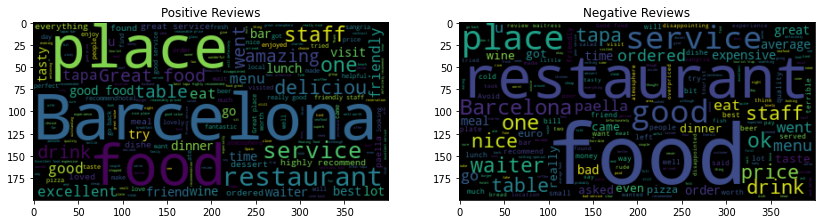

In [38]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14, 6))
# disaster word cloud
txt = " ".join([twt for twt in pos_review.review]) # turn into a single string
wc = WordCloud().generate(txt)
ax1.imshow(wc, interpolation = 'bilinear')
ax1.title.set_text("Positive Reviews")

# non disaster word cloud
txt = " ".join([twt for twt in neg_review.review]) # turn into a single string
wc = WordCloud().generate(txt)
ax2.imshow(wc, interpolation = 'bilinear')
ax2.title.set_text("Negative Reviews");

#### 4.2.4 N-gram Analysis

In [104]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in stop_words]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

stop_words = set(stopwords.words("english"))

In [40]:
# Unigrams
pos_unigrams = defaultdict(int)
neg_unigrams = defaultdict(int)

for rev in pos_review.review:
    for word in generate_ngrams(rev):
        pos_unigrams[word] += 1
        
for rev in neg_review.review:
    for word in generate_ngrams(rev):
        neg_unigrams[word] += 1
        
df_pos_unigrams = pd.DataFrame(sorted(pos_unigrams.items(), key=lambda x: x[1])[::-1])
df_neg_unigrams = pd.DataFrame(sorted(neg_unigrams.items(), key=lambda x: x[1])[::-1])

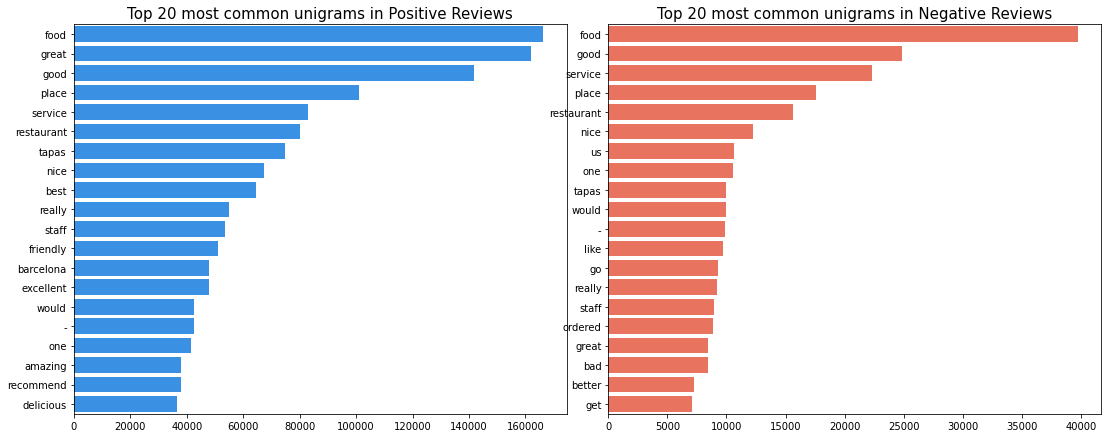

In [41]:
N = 20

fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
plt.tight_layout()

sns.barplot(y=df_pos_unigrams[0].values[:N], x=df_pos_unigrams[1].values[:N], ax=axes[0], color='dodgerblue', alpha = 1)
sns.barplot(y=df_neg_unigrams[0].values[:N], x=df_neg_unigrams[1].values[:N], ax=axes[1], color = 'tomato', alpha = 1)

axes[0].set_title(f'Top {N} most common unigrams in Positive Reviews', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Negative Reviews', fontsize=15);

We see that the unigrams are very similar, and this is to be expected, because both the positive and negative reviews are about the same restaurants and the same products. What's more important is the context in which these words are used, so let's have a look at trigrams or even Ngrams = 5.

In [42]:
# Trigrams
pos_trigrams = defaultdict(int)
neg_trigrams = defaultdict(int)

for rev in pos_review.review:
    for word in generate_ngrams(rev, n_gram = 3):
        pos_trigrams[word] += 1
        
for rev in neg_review.review:
    for word in generate_ngrams(rev, n_gram = 3):
        neg_trigrams[word] += 1
        
df_pos_trigrams = pd.DataFrame(sorted(pos_trigrams.items(), key=lambda x: x[1])[::-1])
df_neg_trigrams = pd.DataFrame(sorted(neg_trigrams.items(), key=lambda x: x[1])[::-1])

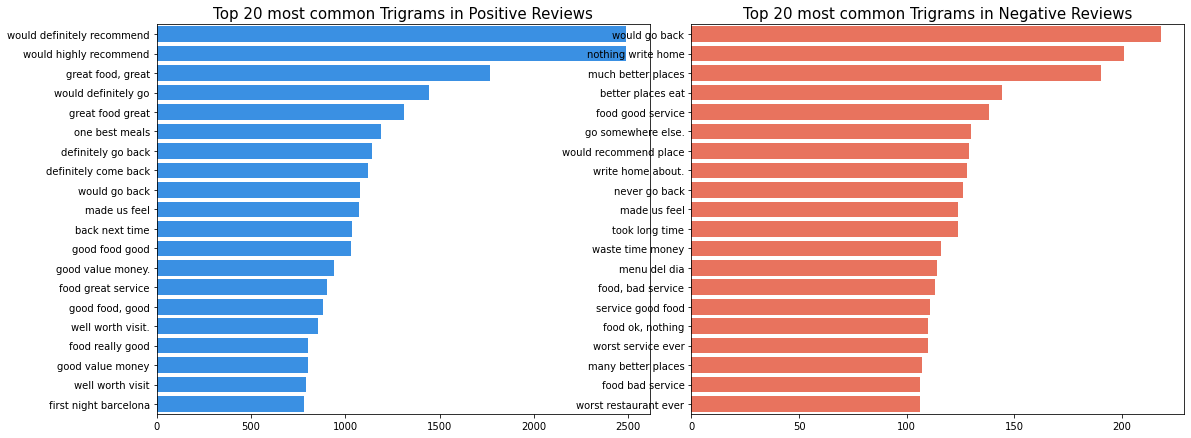

In [43]:
N = 20

fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
plt.tight_layout()

sns.barplot(y=df_pos_trigrams[0].values[:N], x=df_pos_trigrams[1].values[:N], ax=axes[0], color='dodgerblue', alpha = 1)
sns.barplot(y=df_neg_trigrams[0].values[:N], x=df_neg_trigrams[1].values[:N], ax=axes[1], color = 'tomato', alpha = 1)

axes[0].set_title(f'Top {N} most common Trigrams in Positive Reviews', fontsize=15)
axes[1].set_title(f'Top {N} most common Trigrams in Negative Reviews', fontsize=15);

We can now see a lot of differences between positive and negative reviews after adding more context through more consecutive (3) words.

In [44]:
# Pentagrams
pos_pentagrams = defaultdict(int)
neg_pentagrams = defaultdict(int)

for rev in pos_review.review:
    for word in generate_ngrams(rev, n_gram = 5):
        pos_pentagrams[word] += 1
        
for rev in neg_review.review:
    for word in generate_ngrams(rev, n_gram = 5):
        neg_pentagrams[word] += 1
        
df_pos_pentagrams = pd.DataFrame(sorted(pos_pentagrams.items(), key=lambda x: x[1])[::-1])
df_neg_pentagrams = pd.DataFrame(sorted(neg_pentagrams.items(), key=lambda x: x[1])[::-1])

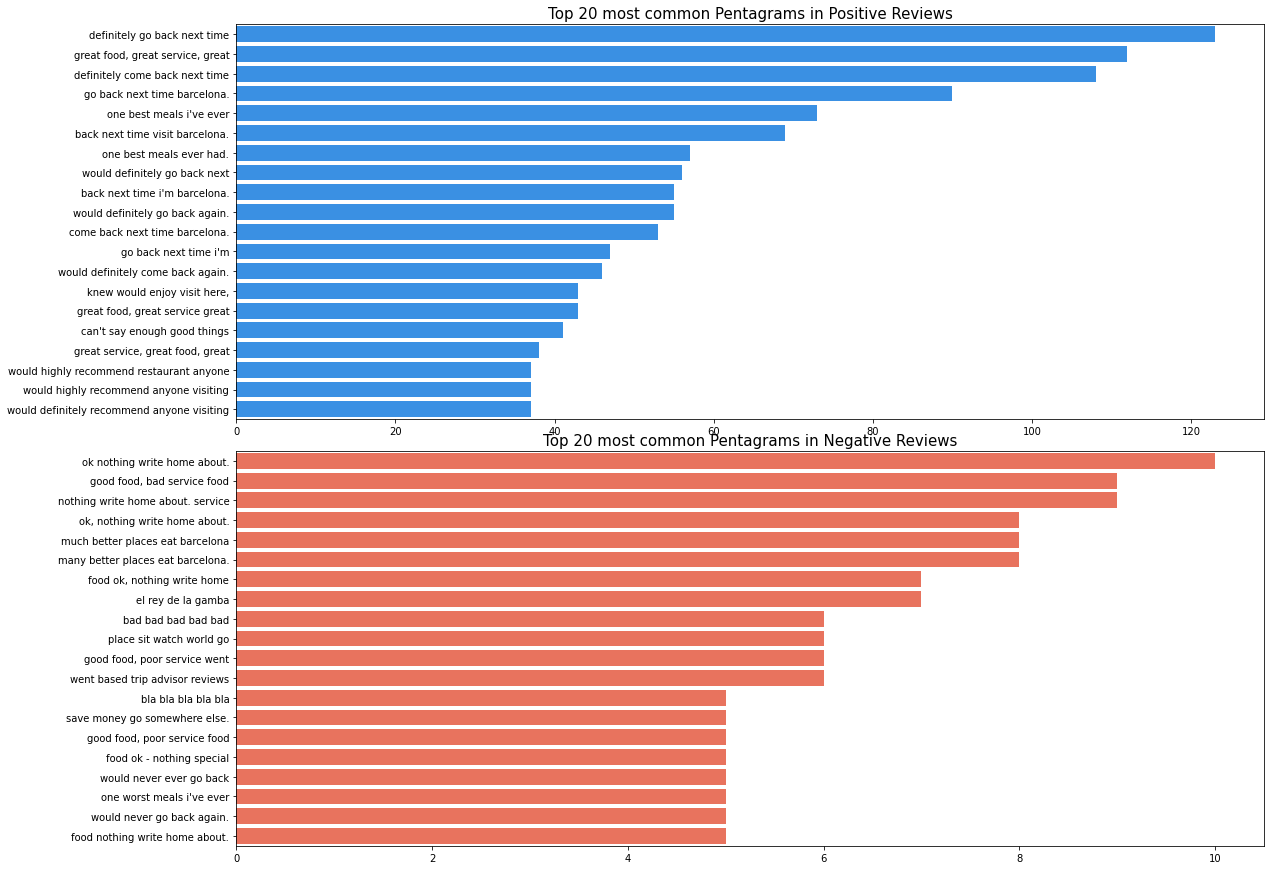

In [45]:
N = 20

fig, axes = plt.subplots(nrows=2, figsize=(15, 12))
plt.tight_layout()

sns.barplot(y=df_pos_pentagrams[0].values[:N], x=df_pos_pentagrams[1].values[:N], ax=axes[0], color='dodgerblue', alpha = 1)
sns.barplot(y=df_neg_pentagrams[0].values[:N], x=df_neg_pentagrams[1].values[:N], ax=axes[1], color = 'tomato', alpha = 1)

axes[0].set_title(f'Top {N} most common Pentagrams in Positive Reviews', fontsize=15)
axes[1].set_title(f'Top {N} most common Pentagrams in Negative Reviews', fontsize=15);

We can now see even more differences between positive and negative reviews after adding more context through more consecutive (5) words.

### 4.3 Summary of EDA Results
#### Data Quality Exploration:
- No missing values
- No duplicate values to be dropped
- The "rating" feature has inconsistent data entries, however, since it is very imbalanced, we will not use the "rating" feature at all, and instead we will rely on "sentiment" as our target. We can drop the "rating" column altogether.
#### Data Characteristic Exploration:
- "sentiment" is not as imbalanced as "rating"， however it is still relatively imbalanced, and **requires attention during modelling process**
- there are some very long reviews that can be considered outliers, and we have decided to only include up to the 90th percentile of data in terms of character length. In otherwords we are only keeping reviews less than or equal to 776 characters in length.
- based on N-gram analysis, we can see that the negative and positive reviews are indeed talking about different topics.




In [ ]:
edadata.drop(['rating','char_len','word_len'], axis = 1, inplace = True)
edadata.info()

In [12]:
edadata.head()

,review_id,rating,review,sentiment
150327,review_646954484,5,The best sushi in Barcelona! What a treat! Fre...,Positive
43614,review_735484397,5,Fantastic !! Food at this place is simply awes...,Positive
113861,review_163709852,4,Worth the wait! Everyone that has been to Bo d...,Positive
331406,review_127320404,5,Come and eat here! The hot and sour soup was t...,Positive
143261,review_150510792,5,Amazing LLamber Finally an amazing & high qual...,Positive


------------

## 5. Data Preparation and Cleaning
Customer review data is typically quite dirty and must be cleaned before feeding into our models. For example, reviews tend to contain a lot of punctuations, emojis and stopwords, these often don't add additional meanings to the text but cause confusion for the algorithms.

There are many steps in preparing text data, the first step is often text cleaning, where we remove text components that are noisy and not useful for our model, such as punctuations,and stop words. The next step is often word tokenization, where we turn raw text into numerical representations that can be understood and analyzed by computers.

### 5.1 Text Cleaning
We will apply the most commonly used cleaning steps here. Note that we will not use word stemming or lemmatizations here, because we will be using word embedding models, and stemmed/lemmatized words may interfere with the performance of these models.

In [17]:
def text_clean(text):
  # Removing urls
  url = re.compile(r'https?://\S+|www\.\S+')
  text = url.sub(r'',text)

  # Removing html tags
  html = re.compile(r'<.*?>')
  text = html.sub(r'',text)

  # Removing emojis
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  text = emoji_pattern.sub(r'', text)

  # Removing punctuations and converting to lower case
  table= str.maketrans('','',string.punctuation)
  text = text.translate(table)

  text= str(text)
  training_tokens = text_to_word_sequence(text,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower = True, split = " ")
    
  # removing stop words
  stop_words = stopwords.words('english')
  stop_words.append('barcelona')
  stop_words = set(stop_words)
  tokens_nostopwords = [word for word in training_tokens if not word in stop_words]
     
  # joining words into a sentence
  text_nostopwords = ' '.join(tokens_nostopwords)
        
  # removing numbers
  text_nonumbers = ''.join(word for word in text_nostopwords if word.isdigit()==0)
  
  return text_nonumbers

In [18]:
clean_review = edadata_trim.copy()
clean_review['review'] = clean_review.review.apply(lambda x: text_clean(x))

In [19]:
edadata_trim.review.head()

150327    The best sushi in Barcelona! What a treat! Fre...
43614     Fantastic !! Food at this place is simply awes...
113861    Worth the wait! Everyone that has been to Bo d...
331406    Come and eat here! The hot and sour soup was t...
143261    Amazing LLamber Finally an amazing & high qual...
Name: review, dtype: object

In [51]:
clean_review.review.head()

150327    best sushi treat freshly made sushi great roll...
43614     fantastic food place simply awesome made reser...
113861    worth wait everyone bo de b tell long wait tru...
331406    come eat hot sour soup best ive since leaving ...
143261    amazing llamber finally amazing high quality d...
Name: review, dtype: object

As we can see the cleaned review data are free to punctuations, stopwords and common emojis.

**All Reviews**

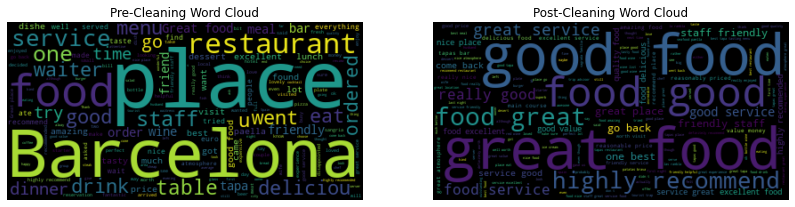

In [52]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14, 6))
# pre-cleaning word cloud
txt = " ".join([word for word in edadata.review]) # turn into a single string
wc = WordCloud().generate(txt)
ax1.imshow(wc, interpolation = 'bilinear')
ax1.axis('off')
ax1.title.set_text("Pre-Cleaning Word Cloud")

# post-cleaning word cloud
txt = " ".join([word for word in clean_review.review]) # turn into a single string
wc = WordCloud().generate(txt)
ax2.imshow(wc, interpolation = 'bilinear')
ax2.title.set_text("Post-Cleaning Word Cloud")
ax2.axis('off');

**Positive Reviews**

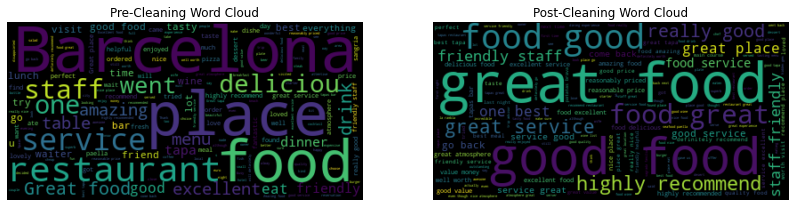

In [53]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14, 6))
# pre-cleaning word cloud
txt = " ".join(set([word for word in pos_review.review])) # turn into a single string
wc = WordCloud().generate(txt)
ax1.imshow(wc, interpolation = 'bilinear')
ax1.axis('off')
ax1.title.set_text("Pre-Cleaning Word Cloud")

# post-cleaning word cloud
txt = " ".join(set([word for word in clean_review[clean_review.sentiment == "Positive"].review])) # turn into a single string
wc = WordCloud().generate(txt)
ax2.imshow(wc, interpolation = 'bilinear')
ax2.title.set_text("Post-Cleaning Word Cloud")
ax2.axis('off');

**Negative Reviews**

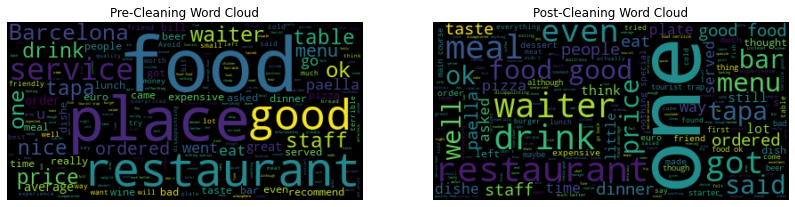

In [54]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14, 6))
# pre-cleaning word cloud
txt = " ".join(set([review for review in neg_review.review])) # turn into a single string
wc = WordCloud().generate(txt)
ax1.imshow(wc, interpolation = 'bilinear')
ax1.axis('off')
ax1.title.set_text("Pre-Cleaning Word Cloud")

# post-cleaning word cloud
txt = " ".join(set([rev for rev in clean_review[clean_review.sentiment == "Negative"].review])) # turn into a single string
wc = WordCloud().generate(txt)
ax2.imshow(wc, interpolation = 'bilinear')
ax2.title.set_text("Post-Cleaning Word Cloud")
ax2.axis('off');

We can very clearly see that our cleaned data make much more sense compared with uncleaned raw data.

### 5.2 GloVe Representation
As mentioned previously, there are many ways to tokenize or represent raw text data. For example, we could use bag-of-words, or Tfidf (term frequency inverse document frequency). We could also use some pre-trained embeddings such as GloVe or FastText.

In this project we will use the popular GloVe approach. Note that the GloVe pretrained corpus model is available in a few varieties: 50D, 100D, 200D and 300D trained on Wikipedia data. And there's also the 200D trained on Twitter data. Here we will use the Twitter GloVe 200D data.

Aftering trialing with various embeddings, I found that the GloVe twitter version had lower coverage than the GloVe wikipedia version. Therefore I am going to proceed with the GloVe 300D (wikipedia) version.

In [15]:
glove_embeddings = np.load('../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl', allow_pickle=True)

Note that Kaggle allows you to use "Add data" to add useful data such as the GloVe embeddings easily. If you were to replicate this you might need to download GloVe and import it locally.

The following functions are from Gunes Evitan, a Kaggle Grandmaster. The original notebook can be found [here](https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert).

In [16]:
import operator

def build_vocab(X):
    
    tweets = X.apply(lambda s: s.split()).values      
    vocab = {}
    
    for tweet in tweets:
        for word in tweet:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1                
    return vocab


def check_embeddings_coverage(X, embeddings):
    
    vocab = build_vocab(X)    
    
    covered = {}
    oov = {}    
    n_covered = 0
    n_oov = 0
    
    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]
            
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))
    
    sorted_oov = sorted(oov.items(), key = operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(edadata['review'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(X_test['review'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

GloVe Embeddings cover 22.83% of vocabulary and 91.54% of text in Training Set
GloVe Embeddings cover 37.14% of vocabulary and 91.49% of text in Test Set


In [65]:
clean_Xtest = X_test.copy()
clean_Xtest['review'] = clean_Xtest.review.apply(lambda x: text_clean(x))

train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(clean_review['review'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(clean_Xtest['review'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Cleaned Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Cleaned Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

GloVe Embeddings cover 36.78% of vocabulary and 97.96% of text in Cleaned Training Set
GloVe Embeddings cover 60.93% of vocabulary and 97.94% of text in Cleaned Test Set


We can verify the benefits of performing text cleaning on our train and test sets! Before our text cleaning process, the GloVe Embeddings only covered about 23% and 37% of the vocabs and 91% of text in training and text sets. But after text cleaning, Embedding covered increased to more than 36% and 60%, and text coverage increased from 91% to 97%!

After cleaning the tweets, glove_embeddings can be deleted and garbage collected because they consume too much memory.

In [18]:
import gc
del glove_embeddings, train_glove_oov, test_glove_oov

gc.collect()

72

Let's now separate our feature (review texts) and target (sentiment) again for further preprocessing.

In [70]:
clean_review.head()

,review_id,review,sentiment
150327,review_646954484,best sushi treat freshly made sushi great roll...,Positive
43614,review_735484397,fantastic food place simply awesome made reser...,Positive
113861,review_163709852,worth wait everyone bo de b tell long wait tru...,Positive
331406,review_127320404,come eat hot sour soup best ive since leaving ...,Positive
143261,review_150510792,amazing llamber finally amazing high quality d...,Positive


Ideally we want to use all the data we have, the more data, the better results from deep learning models. However due to the very limited computational power and RAM we have, we can only use a very small subset of available data. Otherwise the notebook simply runs out of memory and crashes

In [20]:
# We will use the full data for simpler models such as Logistic Regression, but only 30% of the data for deep learning
proportion = 0.3
subset_review = clean_review.sample(frac = proportion)

texts = subset_review['review']
target = subset_review['sentiment']

To actually use the GloVe embeddings, we need to perform a number of steps:

1. Tokenization: We need to first convert strings of text into collections of words or tokens. The benefit of tokenization is that it makes it easier to turn text format into numerical representation that can be processed by computers.
2. Padding: Neural networks require inputs of the same shape and size, however, our texts clearly have different length, therefore, we need to pad them (add values to them) that give them the same length. We can also define maximum number of words for each sentence, if a sentence is longer then we can drop some words.
3. GloVe method: We can derive semantic relationships between words in a text from the co-occurence matrix. We can obtain a vector representation of these words using an unsupervised ML algorithm called GloVe, which stands for Global Vectors for Word Representation. GloVe focuses on word co-occurences over the entire corpus, its embeddings relate to the probabilities of two words appearing together.

**Tokenization and vocab length**
We can see here, that we have a relatively long vocab length

In [21]:
# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

73984

**Padding**
We can see from the output below, that some of the texts have been padded with 0s.

In [22]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(texts), 
    length_long_sentence, 
    padding='post'
)

train_padded_sentences

array([[   15,   157,    34, ...,     0,     0,     0],
       [   12,   413,    22, ...,     0,     0,     0],
       [    2,     6,  2070, ...,     0,     0,     0],
       ...,
       [  569, 73979,    91, ...,     0,     0,     0],
       [  270,   803,     6, ...,     0,     0,     0],
       [  927,   105, 26865, ...,     0,     0,     0]], dtype=int32)

The ideal embedding is 300D version, unfortunately due to limitations in computational power, and in RAM, we can only use the 50D version here. Below is an idea of how long a single Epoch would take using the 300D version.

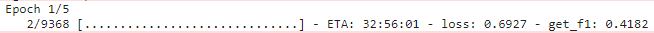

In [23]:
embeddings_dictionary = dict()

# Load Twitter GloVe 50D embeddings 
with open('../input/glove6b50dtxt/glove.6B.50d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

In [24]:
# Now we will load embedding vectors of those words that appear in the
# Glove dictionary. Others will be initialized to 0.
embedding_dim = 50

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.47222   , -0.44545001, -0.51832998, ...,  0.34931999,
         0.33934   ,  0.25499001],
       [-0.35585999,  0.52130002, -0.61070001, ...,  0.27206999,
         0.31305   ,  0.92771   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

------------

## 6. Modelling
### 6.1 Baseline Model - Logistic Regression
It is always important to first establish a baseline model as a basis for model comparison and iteration. For NLP classification tasks, some simple but popular choices include Naive Bayes and Logistic Regression. Here we will use Logistic Regression model as our simple baseline. The Logistic Regression algorithm has the advantages of simplicity, explanability, fast to train and it can even be thought of as a **single-layer neural network with a sigmoid activation function**. Given these advantages, it makes sense to use Logistic Regression as our baseline model.

In [76]:
# First creating our training and validation sets
X = clean_review['review']
y = clean_review['sentiment']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 42, test_size = 0.2, stratify = y)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(299774,) (299774,)
(74944,) (74944,)


In [ ]:
# preprocessing and training
pipe = Pipeline([('tfid', TfidfVectorizer()),  #combines countvectorizer and tfidf transformer in a single step
                 ('model', LogisticRegression(class_weight = {"Positive":0.81, "Negative":0.19}))]) # setting class weight to mitigate imbalanced class distribution

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)

In [84]:
print(f"Logistic Regression achieves a baseline F1 score of {f1_score(y_val, y_pred, pos_label = 'Positive')}")

Logistic Regression achieves a baseline F1 score of 0.9560768261964735


In [80]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

    Negative       0.97      0.62      0.76     13964
    Positive       0.92      1.00      0.96     60980

    accuracy                           0.93     74944
   macro avg       0.95      0.81      0.86     74944
weighted avg       0.93      0.93      0.92     74944



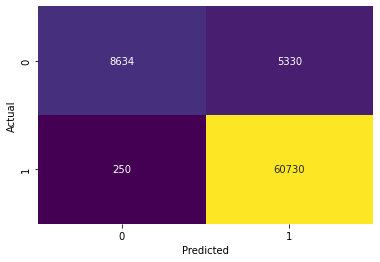

In [81]:
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = 'viridis', annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('Actual');

Our logistic regression baseline achieves an overall F1 score of 0.96. From the confusion matrix and the classification report, we can see that our model does generally well. It achieves a high precision and recall on the positive class (Positive Reviews) and high precision but okay recall on the negative class (Negative Reviews). The overall accuracy is 93%, which is an improved from a naive model that guesses all reviews to be positive (81% positive in raw data).

This very simple model makes quite an improvement from the no-model case!

### 6.2 RNN Model - LSTM baseline
Now we will move onto our second model, the RNN LSTM (long short term memory) model. We will first start with a simple RNN-LSTM structure and use it as our baseline RNN model.

The Long Short-Term Memory or LSTM network is a recurrent neural network that is trained using Backpropogation Through Time BPTT, and can overcome the vanishing gradient problem. Instead of neurons, LSTM networks have memory blocks that are connected into layers.

In [25]:
import gc
del fulldata,edadata, trimdata, clean_review # saving some memory
gc.collect()

69

In [26]:
target = target.replace({"Positive":1,"Negative":0})

In [27]:
# First creating the training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_padded_sentences, 
    target, 
    random_state = 42,
    test_size=0.20, 
    stratify = target
)

So for our model, we will use a simple RNN architecture. The embedding used is based on our GloVe embeddings from before. We will then add a spatial dropout layer, which is for the same purpose as the regular dropout layer, but is more useful when frames in feature maps are correlated, which is often the case in early layers. We then at the LSTM layer with some dropout for regularization. And finally add a fully-connected/dense layer, and use sigmoid activation function since we are doing binary classification. As we can see, this is a very simple, very basic model.

In [29]:
model=Sequential()

embedding=Embedding(input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        weights = [embedding_matrix], 
        input_length=length_long_sentence)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           3699200   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 3,728,705
Trainable params: 3,728,705
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Since our metric is F1 score and since Keras doesn't have an inbuilt F1, we will write a customized version and use it in the compiler
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [36]:
# defining a helper function for plotting results
def show_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('f1')
    ax[1].plot(history.epoch, history.history["get_f1"], label="Train F1")
    ax[1].plot(history.epoch, history.history["val_get_f1"], label="Validation F1")
    ax[0].legend()
    ax[1].legend()

In [32]:
# Using the popular Adam method, with learning rates between 1e-3 ~ 1e-5 are genenrally good starting points

model.compile(loss = keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=get_f1)

In [34]:
# simple model
history = model.fit(
    X_train,
    y_train,
    batch_size = 256,         # batch size tends to be set at 16, 32, 64...etc, let's start with 256
    epochs = 5,             # Let's start with 5 epochs
    validation_data=(X_val, y_val),
)

Epoch 1/5
317/317 [==============================] - 220s 694ms/step - loss: 0.4642 - get_f1: 0.9090 - val_loss: 0.3096 - val_get_f1: 0.9374
Epoch 2/5
317/317 [==============================] - 219s 691ms/step - loss: 0.3157 - get_f1: 0.9271 - val_loss: 0.2732 - val_get_f1: 0.9490
Epoch 3/5
317/317 [==============================] - 220s 695ms/step - loss: 0.2713 - get_f1: 0.9393 - val_loss: 0.2219 - val_get_f1: 0.9542
Epoch 4/5
317/317 [==============================] - 216s 682ms/step - loss: 0.2446 - get_f1: 0.9463 - val_loss: 0.2023 - val_get_f1: 0.9564
Epoch 5/5
317/317 [==============================] - 217s 686ms/step - loss: 0.2252 - get_f1: 0.9510 - val_loss: 0.1950 - val_get_f1: 0.9594


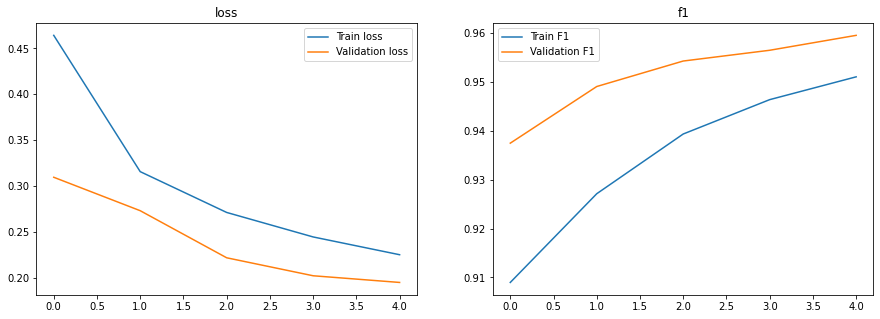

In [37]:
show_history(history)

In [38]:
y_pred = (model.predict(X_val) > 0.5).astype("int32")
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.66      0.76      3425
           1       0.94      0.99      0.96     16812

    accuracy                           0.93     20237
   macro avg       0.92      0.82      0.86     20237
weighted avg       0.93      0.93      0.93     20237



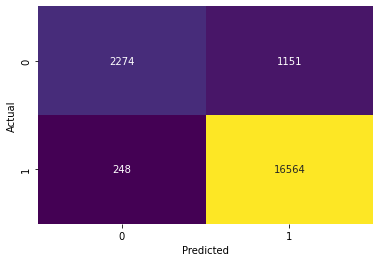

In [39]:
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = 'viridis', annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('Actual');

We can make a number of observations:
- Based on the training history curves, we can see that our model is currently underfitting at 5 epochs, as the loss is still decreasing and f1 increasing with more epochs. 
- But with this underfitting, very simple RNN-LSTM model using 30% of the available training data, we achieved comparable accuracy 93% as the logistic regression model.
- We have achieved comparable F1 score as logistic regression.

Now let's take our model a step further.

### 6.3 RNN Model - LSTM Improved
In the baseline RNN-LSTM model, we used a standard or unidirectional LSTM. It is often argued that Bidirectional LSTMs or BiLSTMs tend to perform better. For [example](https://www.baeldung.com/cs/bidirectional-vs-unidirectional-lstm), BiLSTM is capable of capturing information from both directions of information flow (forward and backward), and therefore has the potential to establish greater context when it comes to NLP. For this reason BiLSTM tend to perform better than LSTM in many cases, but it is also much slower and requires more training time.

The model below is inspired by this [post](https://www.kaggle.com/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm/data).

Hidden layers are the layers between the input and output layers. There is no hard and fast rule on how many hidden layers one should use, and it is often chosen through a trial and error approach. More hidden layers give the model better chance to learn more complex features, however it is NOT true that more complex model are always better models. For simple problems/datasets, complex models often significantly overfit and fail.

In [40]:
model=Sequential()

embedding=Embedding(input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        weights = [embedding_matrix], 
        input_length=length_long_sentence)

model.add(embedding)

model.add(Bidirectional(LSTM(
        length_long_sentence, 
        return_sequences = True, 
        recurrent_dropout=0.2
    )))

model.add(GlobalMaxPool1D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(length_long_sentence, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(length_long_sentence, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           3699200   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 200)          120800    
_________________________________________________________________
global_max_pooling1d (Global (None, 200)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)              

In [41]:
model.compile(loss = keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=get_f1)

history = model.fit(
    X_train,
    y_train,
    batch_size = 256,         # batch size tends to be set at 16, 32, 64...etc, let's start with 256
    epochs = 5,             # Let's start with 5 epochs
    validation_data=(X_val, y_val),
)

Epoch 1/5
317/317 [==============================] - 375s 1s/step - loss: 0.5227 - get_f1: 0.8725 - val_loss: 0.4116 - val_get_f1: 0.9289
Epoch 2/5
317/317 [==============================] - 361s 1s/step - loss: 0.3567 - get_f1: 0.9145 - val_loss: 0.2461 - val_get_f1: 0.9443
Epoch 3/5
317/317 [==============================] - 361s 1s/step - loss: 0.2894 - get_f1: 0.9333 - val_loss: 0.2214 - val_get_f1: 0.9485
Epoch 4/5
317/317 [==============================] - 358s 1s/step - loss: 0.2523 - get_f1: 0.9437 - val_loss: 0.2105 - val_get_f1: 0.9529
Epoch 5/5
317/317 [==============================] - 360s 1s/step - loss: 0.2310 - get_f1: 0.9492 - val_loss: 0.2173 - val_get_f1: 0.9507


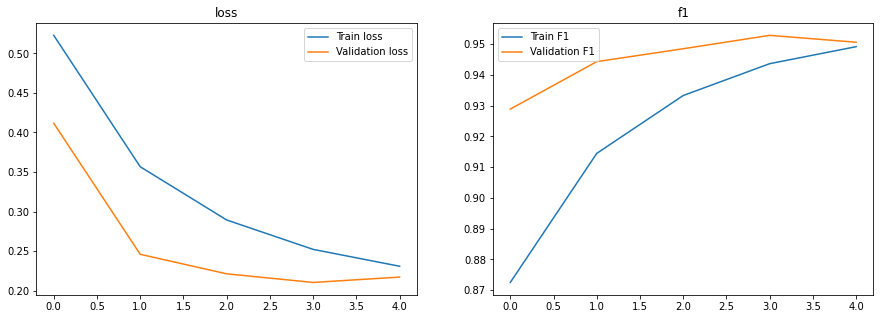

In [42]:
show_history(history)

In [43]:
y_pred = (model.predict(X_val) > 0.5).astype("int32")
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.83      0.78      3425
           1       0.96      0.94      0.95     16812

    accuracy                           0.92     20237
   macro avg       0.85      0.88      0.86     20237
weighted avg       0.92      0.92      0.92     20237



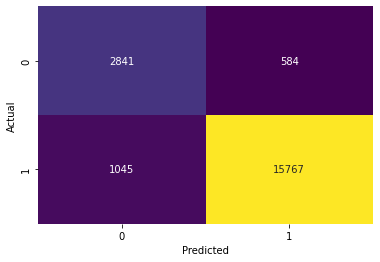

In [44]:
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = 'viridis', annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('Actual');

The more complex BiLSTM model has comparable performance as our simpler LSTM model, but it has picked up a much higher recall on the negative class (negative reviews), that is, it is able to pick up much higher proportion of negative reviews that are actually negative. This might be important for the business, so depending on its particular objectives, either the BiLSTM model or the LSTM model can be chosen. This phenomenon is shown clearly through the confusion matrix plot, where the top left quadrant (Actual = 1 and predicted = 1) has much higher observations than previous models.

-----------

## 7. Hyperparameter Tuning
There are many ways to do hyperparameter tuning:

- First, we could use loop over different combination of hyperparameter values in model fitting, much like doing a grid-search.
- Another popular approach is to automatically search for the optimal hyperparameters using Bayesian Optimization or Random Search. This can be done with Python packages such as Keras Tuner.
- However due to the very limited computing resources available, here we will take a more manual process and try fewer hyparameter combinations so that the notebook won't constantly crash/restart.
- If we had a local GPU or more abundament cloud resources, we would choose a more sophisticated tuning method.

### 7.1 Learning Rate (Dynamic)
Learning rate is one of the most important hyperparameters, we don't want a learning rate that is too high wherein we are unable to converge to global minima, and not too low either such that we are extremely slow to converge. We usually try powers of 10, e.g. 0.0001, 0.001, 0.01 etc. But we can of course try any learning rate and see what works well. 

It is sometimes useful to choose a dynamic learning rate, that starts off high, then gradually slows down as training proceeds. A dynamic learning rate has the benefit of note being stuck on a local minimum prematurely (because of being too low), and not overshooting when convergence is slow (if learning rate is set too high). We will use the ReduceLROnPlateau object to help us complete this task.

In [50]:
model.compile(loss = keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-2),
              metrics=get_f1)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.0001
)

history = model.fit(
    X_train, 
    y_train, 
    class_weight = {1:1, 0:4},
    epochs = 5,
    batch_size = 256,
    validation_data = (X_val, y_val),
    verbose = 1,
    callbacks = [reduce_lr]
)

Epoch 1/5
317/317 [==============================] - 373s 1s/step - loss: 0.3748 - get_f1: 0.9534 - val_loss: 0.3913 - val_get_f1: 0.9166
Epoch 2/5
317/317 [==============================] - 362s 1s/step - loss: 0.2906 - get_f1: 0.9633 - val_loss: 0.2137 - val_get_f1: 0.9628
Epoch 3/5
317/317 [==============================] - 369s 1s/step - loss: 0.2346 - get_f1: 0.9723 - val_loss: 0.2310 - val_get_f1: 0.9571
Epoch 4/5
317/317 [==============================] - 363s 1s/step - loss: 0.1921 - get_f1: 0.9766 - val_loss: 0.2185 - val_get_f1: 0.9449
Epoch 5/5
317/317 [==============================] - 361s 1s/step - loss: 0.1665 - get_f1: 0.9804 - val_loss: 0.3007 - val_get_f1: 0.9537


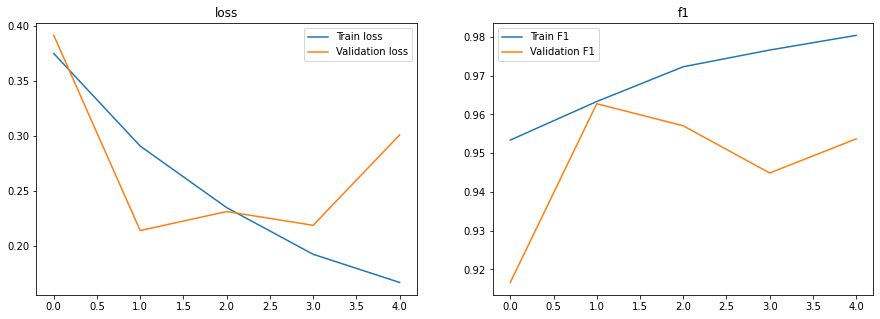

In [51]:
show_history(history)

In [52]:
y_pred = (model.predict(X_val) > 0.5).astype("int32")
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.85      0.80      3425
           1       0.97      0.94      0.95     16812

    accuracy                           0.93     20237
   macro avg       0.86      0.90      0.87     20237
weighted avg       0.93      0.93      0.93     20237



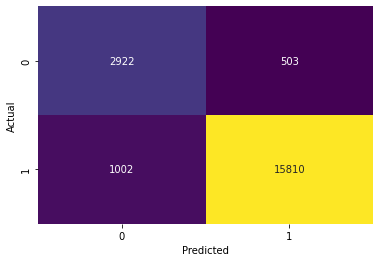

In [53]:
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = 'viridis', annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('Actual');

We can see further improvements in our model performance. Now the F1 score for the negative class has increased to 0.80, for positive reviews it has increased to 0.95. Overall accuracy is at 93%.

### 7.2 Tuning the Optimizer
So far, we have been using the Adam algorithm as our optimizer. Another popular optimizer is RMSprop. It is especially [recommended in RNNs](https://github.com/keras-team/keras/blob/master/keras/optimizers.py#L209).

According to Keras documentation:
> The gist of RMSprop is to:

> * Maintain a moving (discounted) average of the square of gradients
> * Divide the gradient by the root of this average
> * This implementation of RMSprop uses plain momentum, not Nesterov momentum.

> The centered version additionally maintains a moving average of the gradients, and uses that average to estimate the variance.

In [57]:
model.compile(loss = keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.RMSprop(1e-2),   # Using RMSprop optimizer
              metrics=get_f1)

history = model.fit(
    X_train, 
    y_train, 
    class_weight = {1:1, 0:4},
    epochs = 5,
    batch_size = 256,
    validation_data = (X_val, y_val),
    verbose = 1,
    callbacks = [reduce_lr]             # Again we will use a dynamic learning rate
)

Epoch 1/5
317/317 [==============================] - 381s 1s/step - loss: 0.1666 - get_f1: 0.9789 - val_loss: 0.3989 - val_get_f1: 0.9586
Epoch 2/5
317/317 [==============================] - 366s 1s/step - loss: 0.1815 - get_f1: 0.9757 - val_loss: 0.4459 - val_get_f1: 0.9534
Epoch 3/5
317/317 [==============================] - 362s 1s/step - loss: 0.1993 - get_f1: 0.9729 - val_loss: 0.5972 - val_get_f1: 0.9629
Epoch 4/5
317/317 [==============================] - 362s 1s/step - loss: 0.2120 - get_f1: 0.9774 - val_loss: 0.4170 - val_get_f1: 0.9624
Epoch 5/5
317/317 [==============================] - 361s 1s/step - loss: 0.2006 - get_f1: 0.9798 - val_loss: 0.4009 - val_get_f1: 0.9538


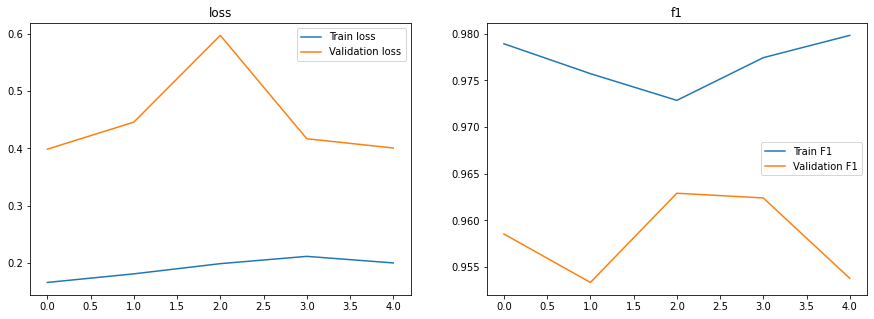

In [58]:
show_history(history)

In [59]:
y_pred = (model.predict(X_val) > 0.5).astype("int32")
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.58      0.72      3425
           1       0.92      0.99      0.96     16812

    accuracy                           0.92     20237
   macro avg       0.93      0.78      0.84     20237
weighted avg       0.92      0.92      0.91     20237



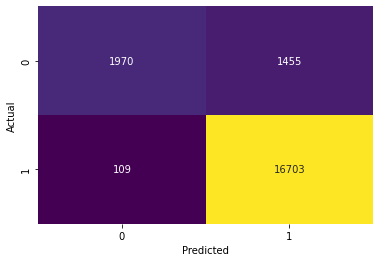

In [60]:
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = 'viridis', annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('Actual');

We can see that the RMSprop optimzer yielded worse results compared with our Adam version. Apart from F1 score for the positive reviews class, F1 score fell across all the other dimensions that we are measuring. We also see that both the validation loss and validation F1 are not optimal in this iteration.

### 7.3 Tuning the Batch Sizes and Increasing Epochs
Batch size is another important hyperparameter. If the batch size is large, learning would become slower, but if the batch size is too small, the weight updates would be quite random and convergence would become difficult. Usually it is recommended to try batch sizes in multiples of 2.

The number of epochs is the same as the number of iterations or times the training data is used to train the model. High epochs will likely cause model overfitting the training data and create generalization problems. If epochs are set to too low, then the model may not have an opportunity to learn all the features, and we would be underfitting.

In [61]:
model.compile(loss = keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-2),
              metrics=get_f1)

history = model.fit(
    X_train, 
    y_train, 
    class_weight = {1:1, 0:4},
    epochs = 10,            # increasing epochs from 5 to 10
    batch_size = 128,       # reducing batch_size from 256 to 128
    validation_data = (X_val, y_val),
    verbose = 1,
    callbacks = [reduce_lr]
)

Epoch 1/10
633/633 [==============================] - 738s 1s/step - loss: 0.2423 - get_f1: 0.9766 - val_loss: 0.2378 - val_get_f1: 0.9526
Epoch 2/10
633/633 [==============================] - 725s 1s/step - loss: 0.2161 - get_f1: 0.9791 - val_loss: 0.2081 - val_get_f1: 0.9614
Epoch 3/10
633/633 [==============================] - 733s 1s/step - loss: 0.2098 - get_f1: 0.9795 - val_loss: 0.1884 - val_get_f1: 0.9597
Epoch 4/10
633/633 [==============================] - 745s 1s/step - loss: 0.2011 - get_f1: 0.9806 - val_loss: 0.1932 - val_get_f1: 0.9605
Epoch 5/10
633/633 [==============================] - 722s 1s/step - loss: 0.1842 - get_f1: 0.9816 - val_loss: 0.2613 - val_get_f1: 0.9513
Epoch 6/10
633/633 [==============================] - 720s 1s/step - loss: 0.2063 - get_f1: 0.9799 - val_loss: 0.2348 - val_get_f1: 0.9600
Epoch 7/10
633/633 [==============================] - 722s 1s/step - loss: 0.1970 - get_f1: 0.9797 - val_loss: 0.2785 - val_get_f1: 0.9573
Epoch 8/10
633/633 [=======

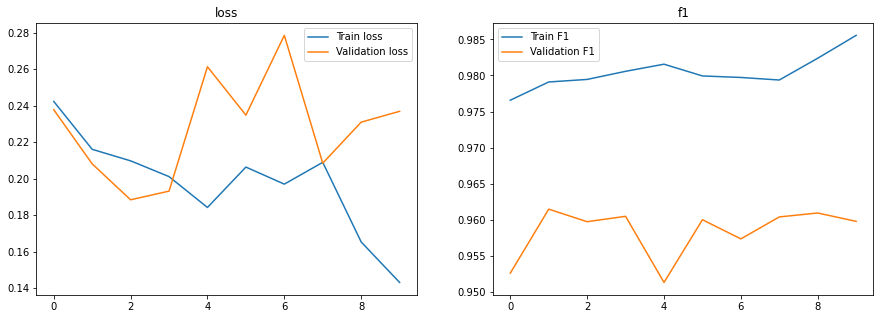

In [62]:
show_history(history)

In [63]:
y_pred = (model.predict(X_val) > 0.5).astype("int32")
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      3425
           1       0.96      0.96      0.96     16812

    accuracy                           0.93     20237
   macro avg       0.88      0.88      0.88     20237
weighted avg       0.93      0.93      0.93     20237



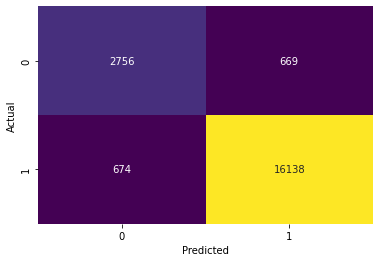

In [64]:
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = 'viridis', annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('Actual');

We can see based on the F1 scores, that this is our best model so far, so we will use it as our final model. Interestingly this model also has the most "balanced" false positive vs. false negatives, it is not as one-sided as some of the other models.

----

## 8. Validation on Test Data

In [69]:
# Remember our true y is in y_test
# We need to preprocess our X_test data

# 1. Clean the data
X_test_clean = X_test.copy()
X_test_clean['review'] = X_test_clean.review.apply(lambda x: text_clean(x))

# 2. Tokenize and pad the data
test = pad_sequences(
            embed(X_test_clean['review']), 
            length_long_sentence, 
            padding='post'
            )



In [73]:
y_pred = (model.predict(test) > 0.5).astype("int32")

In [74]:
y_test = y_test.replace({"Positive":1,"Negative":0})

In [75]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.80      0.81      7758
           1       0.95      0.96      0.96     33878

    accuracy                           0.93     41636
   macro avg       0.89      0.88      0.89     41636
weighted avg       0.93      0.93      0.93     41636



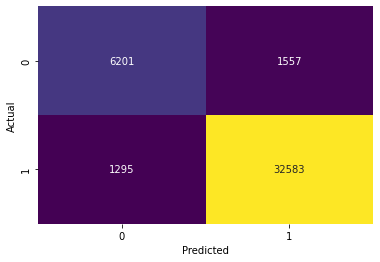

In [76]:
sns.heatmap(confusion_matrix(y_test, y_pred), cmap = 'viridis', annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [77]:
f1_score(y_test, y_pred)

0.9580699226675292

We see that our model has a similar performance on the test set as on the training and validation sets (in fact, it is just slightly better on the test set). This is a good sign as it indicates that our model generalizes well, and we have not overfitted the model to our training and validation data.

Our final model yields an overall F1 score of 0.958. This is the best score so far, and remember we are only use 30% of the available training/validation sets.

----------------

## 9. Topic Modelling
Text data often contain rich information, sometimes too rich to be efficiently analyzed by humans. As we had seen, our customer reviews average around 400-500 characters, with some reviews longer than 1000 characters. It might only take a minute for a human to read through a customer review, but it would take a human 470k minutes to read through all the reviews in our dataset. Assuming 8 hour work days, that's equivalent to 980 work days, or 2.7 years!

Wouldn't it be nice if there was a model that can automatically extract key information/topics from the reviews and then it is up to the human to decide on and filter with a particular topic that they are interested in. Imagine how much time and resources we can save! Topic modelling does exactly this.

Topic modelling is an unsupervised machine learning technique that automatically identifies topics present in a text, and to derive hidden patterns exhibited by a text corpus. It is different from traditional rule-based methods. Topic Models are very useful for the purpose for document clustering, organizing large blocks of textual data, information retrieval from unstructured text and feature selection.

### 9.1 Topic Modelling Using LDA
LDA or Latent Dirchlet Allocation is a popular topic modelling algorithm. It is a generative statistical model that allows observations to be explained by unobserved groups that explain why parts of the data are similar. LDA will take a corpus of documents as an input, assume that each document is a mixture of a small number of topics, and that each word is attributable to one of the documents topics.

In [106]:
from gensim.corpora import Dictionary

For efficiency, let's use a smaller subset of our data for topic modelling.

We are going to attach our predicted labels to the test data (we won't use actual labels, because in real life, we don't have actual labels, and this is the point of our previous prediction model).

In [99]:
predicted_labels = pd.DataFrame(y_pred, columns = ['predicted_label'])
predicted_labels.head()

,predicted_label
0,1
1,1
2,1
3,1
4,1


In [100]:
tm_data = pd.concat([X_test_clean.reset_index(drop = True), predicted_labels], axis = 1)
tm_data.head()

,review_id,rating,review,predicted_label
0,review_472140014,4,almost turned away glad didnt maybe bad timing...,1
1,review_757391715,5,extraordinary best romantic value money thing ...,1
2,review_699665561,5,love place i’m happy found restaurantit super ...,1
3,review_721034338,5,best mojito great paella perfect potatos good ...,1
4,review_723716772,5,delicious unique food boyfriend went meal chak...,1


In [101]:
tm_data = tm_data.sample(frac = 0.3) # taking 30% of test data
tm_data.shape

(12491, 4)

In [102]:
tm_positive = tm_data[tm_data.predicted_label == 1] # positive reviews
tm_negative = tm_data[tm_data.predicted_label == 0] # negative reviews

In [114]:
posreview_dict = Dictionary(tm_positive.review.str.split())
negreview_dict = Dictionary(tm_negative.review.str.split())

Get a preview of what the dictionary looks like.

In [118]:
list(posreview_dict.token2id.items())[-5:]

[('flassaders', 20689),
 ('princesa', 20690),
 ('restaurente', 20691),
 ('romanic', 20692),
 ('chiose', 20693)]

Now we will turn the dictionary into a simple bag of words.

In [119]:
posreview_bow = [posreview_dict.doc2bow(review) for review in tm_positive.review.str.split()]
negreview_bow = [negreview_dict.doc2bow(review) for review in tm_negative.review.str.split()]

Now we can apply the LDA model. We will use Gensim's implementation here.

In [121]:
from gensim.models.ldamodel import LdaModel

# We will set number of topics to 10 for now
k = 10
pos_lda = LdaModel(posreview_bow, 
                   num_topics = k, 
                   id2word = posreview_dict, 
                   random_state = 42, 
                   passes = 10) # Let's train for 10 passes or epochs

neg_lda = LdaModel(negreview_bow, 
                   num_topics = k, 
                   id2word = negreview_dict, 
                   random_state = 42, 
                   passes = 10)

Let's have a look at our LDA results!

In [122]:
pos_lda.show_topics()

[(0,
  '0.036*"burger" + 0.027*"burgers" + 0.020*"bar" + 0.013*"back" + 0.012*"drink" + 0.010*"beach" + 0.010*"music" + 0.009*"day" + 0.008*"cocktails" + 0.008*"fries"'),
 (1,
  '0.023*"crepes" + 0.016*"snacks" + 0.013*"resturant" + 0.010*"tastfull" + 0.010*"creperie" + 0.009*"lunches" + 0.008*"france" + 0.008*"specialties" + 0.007*"persons" + 0.006*"quiche"'),
 (2,
  '0.077*"tapas" + 0.023*"de" + 0.018*"bar" + 0.017*"bravas" + 0.013*"patatas" + 0.012*"sangria" + 0.012*"la" + 0.010*"place" + 0.010*"cava" + 0.010*"beer"'),
 (3,
  '0.018*"beers" + 0.013*"tiramisu" + 0.013*"kebab" + 0.012*"craft" + 0.011*"toppings" + 0.010*"handy" + 0.010*"txapela" + 0.009*"g" + 0.009*"private" + 0.009*"game"'),
 (4,
  '0.045*"best" + 0.036*"paella" + 0.021*"seafood" + 0.021*"pizza" + 0.017*"good" + 0.017*"one" + 0.015*"ever" + 0.013*"place" + 0.011*"restaurant" + 0.009*"ive"'),
 (5,
  '0.071*"food" + 0.057*"good" + 0.056*"great" + 0.038*"service" + 0.036*"nice" + 0.031*"place" + 0.024*"friendly" + 0.020*

In [123]:
neg_lda.show_topics()

[(0,
  '0.020*"us" + 0.019*"food" + 0.012*"service" + 0.010*"table" + 0.009*"restaurant" + 0.009*"good" + 0.008*"drinks" + 0.008*"order" + 0.008*"asked" + 0.008*"waiter"'),
 (1,
  '0.008*"like" + 0.008*"dog" + 0.008*"woman" + 0.007*"stress" + 0.007*"disappointing" + 0.006*"told" + 0.006*"drinks" + 0.006*"table" + 0.006*"dogs" + 0.005*"rough"'),
 (2,
  '0.043*"food" + 0.030*"good" + 0.020*"average" + 0.019*"ok" + 0.013*"service" + 0.013*"place" + 0.011*"tapas" + 0.010*"nice" + 0.010*"better" + 0.008*"great"'),
 (3,
  '0.027*"food" + 0.013*"staff" + 0.012*"service" + 0.012*"rude" + 0.010*"place" + 0.009*"never" + 0.008*"terrible" + 0.008*"bad" + 0.008*"us" + 0.007*"would"'),
 (4,
  '0.012*"never" + 0.008*"know" + 0.008*"years" + 0.007*"go" + 0.007*"don’t" + 0.006*"argue" + 0.006*"place" + 0.006*"say" + 0.006*"money" + 0.005*"waste"'),
 (5,
  '0.020*"pizza" + 0.019*"good" + 0.016*"tapas" + 0.013*"food" + 0.012*"service" + 0.009*"nice" + 0.008*"go" + 0.008*"place" + 0.007*"would" + 0.007*"

The outputs represent 10 topics for the positive reviews and negative reviews respectively. It consists of the top key words along with the associated weight distribution for that topic.

For example, let's have a look at Topic 3 for the negative reviews and understand what it means.

**Negative Topic 3:**
- Staff service rude terrible, seem to suggest that the staff at the restaurant was rude, and service was terrible. This describes the experience the customer had endured while eating at the restaurant.
- Place bad never us would, seem to suggest that the customer would never come back to this restaurant again. This describes the customer's action or potential future action.

Of course we can repeat this analysis for any topic and even assign a topic name for each topic. For example, we might name topic 3 as **"Terrible serivce driving customers away"**.

### 9.2 Visualizing the Topics
It is often a good ideas to visualize topics from a topic model. We can achieve this using the PyLDAvis library.

The left panel is a representation of distance between the topics, while the right panel allows us to see the key words/expressions in each topic.

**Positive Reviews**

In [125]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

posvis = pyLDAvis.gensim.prepare(pos_lda, posreview_bow, dictionary= pos_lda.id2word)
posvis

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.289689 -0.013791       1        1  40.740748
6      0.232087  0.055535       2        1  28.529446
5      0.277155  0.043109       3        1  14.967521
4      0.175856  0.117370       4        1   7.147093
2      0.061348 -0.319950       5        1   3.665422
7     -0.191884  0.002328       6        1   1.495471
0     -0.127095  0.055344       7        1   1.444220
9     -0.241765  0.022937       8        1   0.809567
3     -0.239502  0.019879       9        1   0.786115
1     -0.235888  0.017239      10        1   0.414398, topic_info=                  Term         Freq        Total Category  logprob  loglift
166              tapas  3544.000000  3544.000000  Default  30.0000  30.0000
56                food  8723.000000  8723.000000  Default  29.0000  29.0000
5                great  6934.000000  6934.000000  Default  28.0000  28.0000
26                good  7177.000000  7177.000000  Default  27.0000  27.0000
1                 best  2305.000000  2305.000000  Default  26.0000  26.0000
33                nice  2849.000000  2849.000000  Default  25.0000  25.0000
184            service  4609.000000  4609.000000  Default  24.0000  24.0000
325                bar  1379.000000  1379.000000  Default  23.0000  23.0000
34               place  4558.000000  4558.000000  Default  22.0000  22.0000
552             paella   987.000000   987.000000  Default  21.0000  21.0000
109           friendly  2410.000000  2410.000000  Default  20.0000  20.0000
81                back  1606.000000  1606.000000  Default  19.0000  19.0000
10                 one  1990.000000  1990.000000  Default  18.0000  18.0000
254             really  2188.000000  2188.000000  Default  17.0000  17.0000
557            seafood   668.000000   668.000000  Default  16.0000  16.0000
67               staff  2619.000000  2619.000000  Default  15.0000  15.0000
309              pizza   571.000000   571.000000  Default  14.0000  14.0000
168            amazing  1924.000000  1924.000000  Default  13.0000  13.0000
462          recommend  1778.000000  1778.000000  Default  12.0000  12.0000
260              tasty  1081.000000  1081.000000  Default  11.0000  11.0000
1148             drink   531.000000   531.000000  Default  10.0000  10.0000
1011                de   493.000000   493.000000  Default   9.0000   9.0000
369         atmosphere  1409.000000  1409.000000  Default   8.0000   8.0000
55           excellent  2454.000000  2454.000000  Default   7.0000   7.0000
366               ever   589.000000   589.000000  Default   6.0000   6.0000
835                day   840.000000   840.000000  Default   5.0000   5.0000
403               busy   600.000000   600.000000  Default   4.0000   4.0000
163         restaurant  4505.000000  4505.000000  Default   3.0000   3.0000
217               wine  1786.000000  1786.000000  Default   2.0000   2.0000
173          delicious  2480.000000  2480.000000  Default   1.0000   1.0000
1320           pinchos   125.273014   125.995404   Topic1  -7.1163   0.8922
159                las   107.771450   108.501321   Topic1  -7.2668   0.8912
1210         extensive    82.642503    83.365025   Topic1  -7.5323   0.8892
2958              mins    79.180213    79.902755   Topic1  -7.5751   0.8889
1547             group   247.218696   249.592913   Topic1  -6.4365   0.8884
4103             placa    70.342845    71.065854   Topic1  -7.6934   0.8877
2390             hours   169.999689   171.775198   Topic1  -6.8110   0.8876
2729               gin    64.046909    64.769371   Topic1  -7.7872   0.8867
2895       inexpensive    63.463561    64.185971   Topic1  -7.7963   0.8866
972              daily    62.285182    63.008379   Topic1  -7.8151   0.8864
1582            mainly    60.209588    60.931990   Topic1  -7.8490   0.8860
3507          starting    61.683446    62.424248   Topic1  -7.8248   0.8860
1267            centre    58.710489    59

**Negative Reviews**

In [126]:
pyLDAvis.enable_notebook()

negvis = pyLDAvis.gensim.prepare(neg_lda, negreview_bow, dictionary= neg_lda.id2word)
negvis

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.140438 -0.106885       1        1  27.433722
9      0.154300 -0.003400       2        1  25.937878
8      0.109007 -0.037166       3        1  14.578153
7      0.117438  0.087286       4        1  11.076515
3      0.054896 -0.149809       5        1   6.921041
5      0.063394  0.061183       6        1   5.835382
2      0.040669  0.179373       7        1   4.527364
4     -0.208840 -0.029899       8        1   1.519990
1     -0.238292  0.003197       9        1   1.308024
6     -0.233010 -0.003880      10        1   0.861931, topic_info=                 Term         Freq        Total Category  logprob  loglift
8                food  2115.000000  2115.000000  Default  30.0000  30.0000
52               good  1523.000000  1523.000000  Default  29.0000  29.0000
304           average   381.000000   381.000000  Default  28.0000  28.0000
17              never   253.000000   253.000000  Default  27.0000  27.0000
127                ok   396.000000   396.000000  Default  26.0000  26.0000
4                even   355.000000   355.000000  Default  25.0000  25.0000
491             tapas   549.000000   549.000000  Default  24.0000  24.0000
122               got   290.000000   290.000000  Default  23.0000  23.0000
20              place   945.000000   945.000000  Default  22.0000  22.0000
381             pizza   145.000000   145.000000  Default  21.0000  21.0000
179             table   418.000000   418.000000  Default  20.0000  20.0000
147              nice   549.000000   549.000000  Default  19.0000  19.0000
181                us   792.000000   792.000000  Default  18.0000  18.0000
12               like   507.000000   507.000000  Default  17.0000  17.0000
691              rude   244.000000   244.000000  Default  16.0000  16.0000
23            service  1209.000000  1209.000000  Default  15.0000  15.0000
9                  go   422.000000   422.000000  Default  14.0000  14.0000
95                bar   187.000000   187.000000  Default  13.0000  13.0000
167            drinks   330.000000   330.000000  Default  12.0000  12.0000
299              told   243.000000   243.000000  Default  11.0000  11.0000
123              half   160.000000   160.000000  Default  10.0000  10.0000
192             euros   247.000000   247.000000  Default   9.0000   9.0000
119     disappointing   191.000000   191.000000  Default   8.0000   8.0000
498             salad   123.000000   123.000000  Default   7.0000   7.0000
156          terrible   221.000000   221.000000  Default   6.0000   6.0000
204             staff   497.000000   497.000000  Default   5.0000   5.0000
101              know   134.000000   134.000000  Default   4.0000   4.0000
256            better   340.000000   340.000000  Default   3.0000   3.0000
99              great   363.000000   363.000000  Default   2.0000   2.0000
60            nothing   245.000000   245.000000  Default   1.0000   1.0000
2380             till    55.803071    56.504753   Topic1  -6.2395   1.2809
795            bother    45.310343    46.030237   Topic1  -6.4477   1.2776
1740       eventually    39.363132    40.062019   Topic1  -6.5885   1.2758
353           waiting   167.187793   170.565207   Topic1  -5.1422   1.2734
2242             upon    28.565297    29.273845   Topic1  -6.9091   1.2689
1243          telling    25.227816    25.918406   Topic1  -7.0333   1.2664
1727           ruined    26.599572    27.344516   Topic1  -6.9804   1.2658
1555           placed    23.305099    23.997302   Topic1  -7.1126   1.2641
9910            grams    22.054435    22.766975   Topic1  -7.1678   1.2616
638              hake    20.910274    21.595233   Topic1  -7.2210   1.2612
1138            moved    19.470781    20.156054   Topic1  -7.2924   1.2588
1086       approached    20.858785    21.594201   Topic1  -7.2235   1.2587
2665          members    18.989804    19.678294   Topic1  -7.3174   1.2578
850      

------------

## 10. Analysis and Summary of Results

### 8.1 Summary of Results

### 8.2 Summary of Modelling and Tuning Choices

-------------

## 11. Conclusion

----------